<a href="https://colab.research.google.com/github/mayanku1111/SFprojects/blob/main/W2Winference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 80.9 MB/s eta 0:00:00


In [3]:
%cd /content/drive/MyDrive/kaggle/weights2weights/

/content/drive/MyDrive/kaggle/weights2weights


In [4]:
import os
os.getcwd()

'/content/drive/MyDrive/kaggle/weights2weights'

In [5]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join("", "..")))
import torch
import gc
import warnings
warnings.filterwarnings("ignore")
from PIL import Image
from lora_w2w import LoRAw2w
from utils import load_models, inference, save_model_w2w, save_model_for_diffusers
from editing import get_direction, edit_inference, debias
device = "cuda"

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [6]:
if torch.cuda.is_available():
  print(torch.cuda.get_device_name())

NVIDIA L4


In [7]:
mean = torch.load("/content/drive/MyDrive/kaggle/weights2weights/files/mean.pt").bfloat16().to(device)
std = torch.load("/content/drive/MyDrive/kaggle/weights2weights/files/std.pt").bfloat16().to(device)
v = torch.load("/content/drive/MyDrive/kaggle/weights2weights/files/V.pt").bfloat16().to(device)
proj = torch.load("/content/drive/MyDrive/kaggle/weights2weights/files/proj_1000pc.pt").bfloat16().to(device)
pinverse = torch.load("/content/drive/MyDrive/kaggle/weights2weights/files/pinverse_1000pc.pt").bfloat16().to(device)
df = torch.load("/content/drive/MyDrive/kaggle/weights2weights/files/identity_df.pt")
weight_dimensions = torch.load("/content/drive/MyDrive/kaggle/weights2weights/files/weight_dimensions.pt")

In [8]:
unet, vae, text_encoder, tokenizer, noise_scheduler = load_models(device)

model_index.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/379 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.78k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/606 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [9]:
weights0 = torch.load("/content/drive/MyDrive/kaggle/weights2weights/w2wmodel.pt").to(device)
weights1 = torch.load("/content/drive/MyDrive/kaggle/weights2weights/lecunsaved/w2wmodel.pt").to(device)

In [10]:
# free up memory if reinitializing model
if 'network' in globals():
    del network
    network = None
    gc.collect()
    torch.cuda.empty_cache()
    unet, _, _, _, _ = load_models(device)
# initialize model
network = LoRAw2w(unet = unet,
                proj = weights0,
                mean = mean,
                std = std,
                v = v[:,:10000],
                rank=1,
                multiplier=1.0,
                alpha=27,
                train_method="xattn-strict",
                ).to(device, dtype=torch.bfloat16)

In [11]:
# free up memory if reinitializing model
if 'network' in globals():
    del network
    network = None
    gc.collect()
    torch.cuda.empty_cache()
    unet, _, _, _, _ = load_models(device)
# initialize model
network = LoRAw2w(unet = unet,
                proj = weights1,
                mean = mean,
                std = std,
                v = v[:,:10000],
                rank=1,
                multiplier=1.0,
                alpha=27,
                train_method="xattn-strict",
                ).to(device, dtype=torch.bfloat16)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 51/51 [00:03<00:00, 14.10it/s]


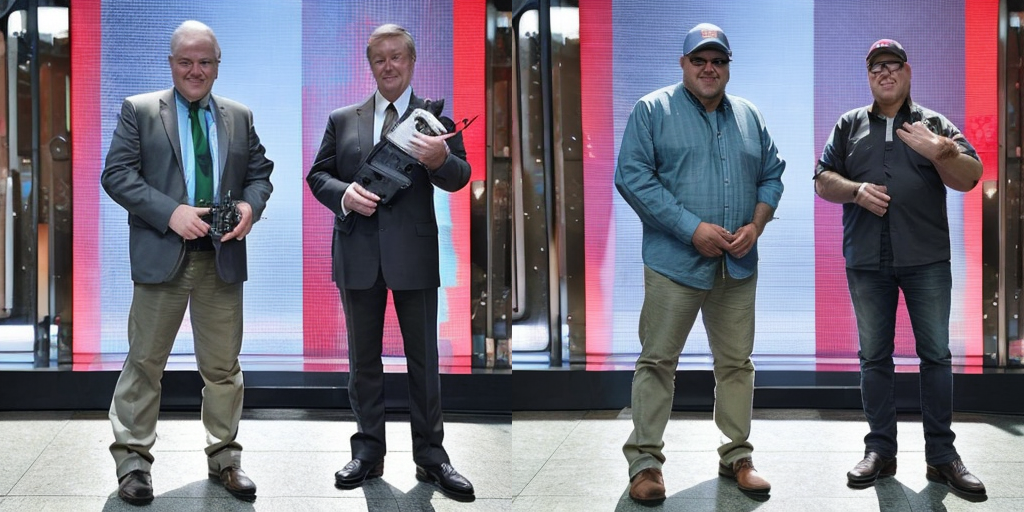

In [16]:
#inference parameters
prompt = "sks person standing next to sks person2"
negative_prompt = "low quality, blurry, unfinished, cartoon"
guidance_scale = 2.5
seed = 99
ddim_steps = 50
# injection step
start_noise = 700
# random seed generator
generator = torch.Generator(device=device)

images = []
#run inference
for weight in [weights0, weights1]:
    image = edit_inference(network, weight, unet, vae, text_encoder, tokenizer, prompt, negative_prompt, guidance_scale, noise_scheduler, ddim_steps, start_noise, seed, generator, device)
    image = image.detach().cpu().float().permute(0, 2, 3, 1).numpy()[0]
    image = Image.fromarray((image * 255).round().astype("uint8"))
    images.append(image)

### display images
w, h = 512,512
grid = Image.new('RGB', size=(2*512, 1*512))
grid_w, grid_h = grid.size
for i, img in enumerate(images):
    grid.paste(img, box=(i%2*w, i//2*h))
grid